In [27]:
#importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Ridge

In [2]:
#displaying the car price data set as a dataframe
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")
pd.set_option('display.max_columns',50)
display(df.head())

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [3]:
df.shape

(9704, 11)

In [4]:
df.describe

<bound method NDFrame.describe of       engine_displacement  num_cylinders  horsepower  vehicle_weight  \
0                     170            3.0       159.0     3413.433759   
1                     130            5.0        97.0     3149.664934   
2                     170            NaN        78.0     3079.038997   
3                     220            4.0         NaN     2542.392402   
4                     210            1.0       140.0     3460.870990   
...                   ...            ...         ...             ...   
9699                  140            5.0       164.0     2981.107371   
9700                  180            NaN       154.0     2439.525729   
9701                  220            2.0       138.0     2583.471318   
9702                  230            4.0       177.0     2905.527390   
9703                  270            3.0       140.0     2908.043477   

      acceleration  model_year  origin fuel_type         drivetrain  \
0             17.7        2003

In [5]:
df.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

# Data Preprocessing

In [6]:
#checking for NaN values
print('checking for NaN values from each column: \n',df.isna().sum()) 

checking for NaN values from each column: 
 engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64


In [7]:
# Checking for duplicates
df.duplicated().sum()

0

In [8]:
# Dropping columns not needed for regression model
selected_columns = ['fuel_efficiency_mpg', 'engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
df = df[selected_columns]


In [9]:
#cleaning column
df = df.rename(columns={'horsepower': 'horse_power'})

In [10]:
df.columns

Index(['fuel_efficiency_mpg', 'engine_displacement', 'horse_power',
       'vehicle_weight', 'model_year'],
      dtype='object')

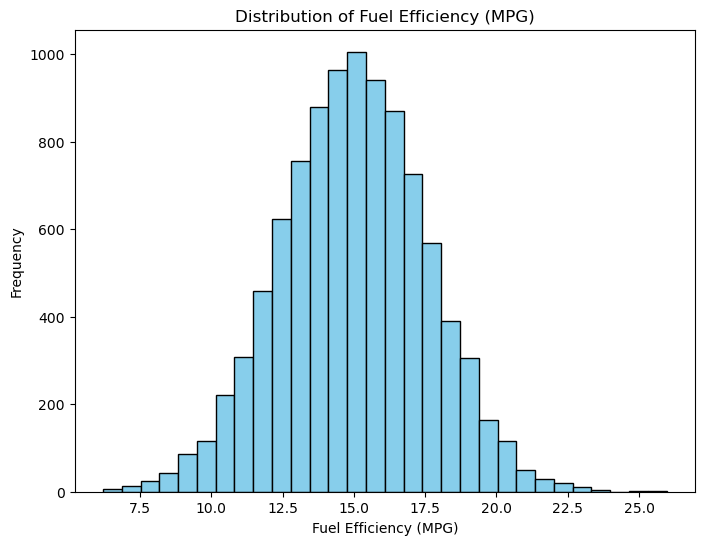

In [11]:
# check the data distribution for fuel_efficiency_mpg
plt.figure(figsize=(8, 6))
plt.hist(df['fuel_efficiency_mpg'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Fuel Efficiency (MPG)')
plt.xlabel('Fuel Efficiency (MPG)')
plt.ylabel('Frequency')
plt.show()

In [14]:
#What's the median (50% percentile) for variable 'horsepower'?
df['horse_power'].median()

149.0

In [15]:
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [16]:
n_val,n_test,n_train

(1940, 1940, 5824)

In [17]:
df.iloc[:10]

,fuel_efficiency_mpg,engine_displacement,horse_power,vehicle_weight,model_year
0,13.231729,170,159.0,3413.433759,2003
1,13.688217,130,97.0,3149.664934,2007
2,14.246341,170,78.0,3079.038997,2018
3,16.912736,220,NaN,2542.392402,2009
4,12.488369,210,140.0,3460.870990,2009
5,17.271818,190,NaN,2484.883986,2008
6,13.210412,240,127.0,3006.542287,2012
7,12.848884,150,239.0,3638.657780,2020
8,16.823554,250,174.0,2714.219310,2016
9,12.298355,150,123.0,3509.036569,2005


In [18]:
# split the dataset
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train + n_val]
df_test = df.iloc[n_train + n_val:]

In [19]:
idx = np.arange(n)

In [21]:
#Shuffling the dataset (the filtered one you created above), use seed 42.idx = np.arange(n)
np.random.shuffle(idx)

df = df.iloc[idx]

np.random.seed(42)

In [22]:
df_train.head()

,fuel_efficiency_mpg,engine_displacement,horse_power,vehicle_weight,model_year
0,13.231729,170,159.0,3413.433759,2003
1,13.688217,130,97.0,3149.664934,2007
2,14.246341,170,78.0,3079.038997,2018
3,16.912736,220,NaN,2542.392402,2009
4,12.488369,210,140.0,3460.870990,2009


In [23]:
len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

In [24]:
#Filling missing values with mean
means = df_train.mean()
df_train_mean = df_train.fillna(means)
df_val_mean = df_val.fillna(means)

In [25]:
#Filling missing values with 0
df_train_0 = df_train.fillna(0)
df_val_0 = df_val.fillna(0)

In [26]:
# separate target and features
X_train_0 = df_train_0.drop('fuel_efficiency_mpg', axis=1)
y_train_0 = df_train_0['fuel_efficiency_mpg']

X_val_0 = df_val_0.drop('fuel_efficiency_mpg', axis=1)
y_val_0 = df_val_0['fuel_efficiency_mpg']

X_train_mean = df_train_mean.drop('fuel_efficiency_mpg', axis=1)
y_train_mean = df_train_mean['fuel_efficiency_mpg']

X_val_mean = df_val_mean.drop('fuel_efficiency_mpg', axis=1)
y_val_mean = df_val_mean['fuel_efficiency_mpg']


In [29]:
# model 1: fill with 0
model_0 = LinearRegression()
model_0.fit(X_train_0, y_train_0)
pred_0 = model_0.predict(X_val_0)
rmse_0 = root_mean_squared_error(y_val_0, pred_0)
print('RMSE (fill 0):', round(rmse_0, 2))

RMSE (fill 0): 0.52


In [32]:
# model 2: fill with mean
model_mean = LinearRegression()
model_mean.fit(X_train_mean, y_train_mean)
pred_mean = model_mean.predict(X_val_mean)
rmse_mean = root_mean_squared_error(y_val_mean, pred_mean)
print('RMSE (fill mean):', round(rmse_mean, 2))

RMSE (fill mean): 0.46


In [33]:
print('RMSE (fill mean):', round(rmse_mean, 2))

RMSE (fill mean): 0.46


In [34]:
#Preparing the data (fill NAs with 0)
df_train_0 = df_train.fillna(0)
df_val_0 = df_val.fillna(0)

X_train = df_train_0.drop('fuel_efficiency_mpg', axis=1)
y_train = df_train_0['fuel_efficiency_mpg']

X_val = df_val_0.drop('fuel_efficiency_mpg', axis=1)
y_val = df_val_0['fuel_efficiency_mpg']


In [35]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = {}

for r in r_values:
    model = Ridge(alpha=r)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    rmse_scores[r] = round(rmse, 2)

rmse_scores

{0: 0.52, 0.01: 0.52, 0.1: 0.52, 1: 0.52, 5: 0.52, 10: 0.52, 100: 0.52}

In [36]:
seeds = [0,1,2,3,4,5,6,7,8,9]
rmse_list = []

for seed in seeds:
    # Shuffle
    np.random.seed(seed)
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_shuffled = df.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    
    # Fill missing values with 0
    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)
    
    # Features and target
    X_train = df_train.drop('fuel_efficiency_mpg', axis=1)
    y_train = df_train['fuel_efficiency_mpg']
    
    X_val = df_val.drop('fuel_efficiency_mpg', axis=1)
    y_val = df_val['fuel_efficiency_mpg']
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    # Computing RMSE
    rmse = root_mean_squared_error(y_val, preds)
    rmse_list.append(rmse)

# Standard deviation of RMSEs
std_rmse = np.std(rmse_list)
print(round(std_rmse, 3))

0.009


In [37]:
#Shuffling with a seed 9
np.random.seed(9)
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df= df.iloc[idx]

df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train+n_val]
df_test = df.iloc[n_train+n_val:]

In [38]:
#Combine train and validation
df_train_full = pd.concat([df_train, df_val], ignore_index=True)

In [39]:
#Filling missing values with 0
df_train_full = df_train_full.fillna(0)
df_test = df_test.fillna(0)

In [40]:
#Splitting features and target
X_train = df_train_full.drop('fuel_efficiency_mpg', axis=1)
y_train = df_train_full['fuel_efficiency_mpg']
X_test = df_test.drop('fuel_efficiency_mpg', axis=1)
y_test = df_test['fuel_efficiency_mpg']

In [41]:
#Train Ridge model with r=0.001
model = Ridge(alpha=0.001)
model.fit(X_train, y_train)

Ridge(alpha=0.001)

In [42]:
#Predict and compute RMSE on test set
preds = model.predict(X_test)
rmse_test = root_mean_squared_error (y_test, preds)
print(round(rmse_test, 2))

0.52
